In [91]:
CMPD_or_DMSO = "CMPD"

In [92]:
import pandas as pd

df = pd.read_csv("all_plate_df.csv")

In [93]:
dmso_plates = [col for col in df["Metadata_Plate"].unique() if "DMSO" in col]
df["Metadata_cmpd_or_control"] = "CMPD"
df.loc[df["Metadata_Plate"].isin(dmso_plates), "Metadata_Treatment_concentration"] = (
    "DMSO_0"
)
df.loc[df["Metadata_Plate"].isin(dmso_plates), "Metadata_Treatment"] = "DMSO"
df.loc[df["Metadata_Plate"].isin(dmso_plates), "Metadata_Concentration"] = 0.0
df.loc[df["Metadata_Plate"].isin(dmso_plates), "Metadata_cmpd_or_control"] = "DMSO"

In [94]:
meta_cols = [col for col in df.columns if col.startswith("Metadata_")]
measurement_cols = [col for col in df.columns if not col.startswith("Metadata_")]
variances_df = {}
for dmso_or_cmpd in df["Metadata_cmpd_or_control"].unique():
    subset_df = df[df["Metadata_cmpd_or_control"] == dmso_or_cmpd]
    variances_df[dmso_or_cmpd] = subset_df[measurement_cols].var()
    
variances_df = pd.DataFrame(variances_df)

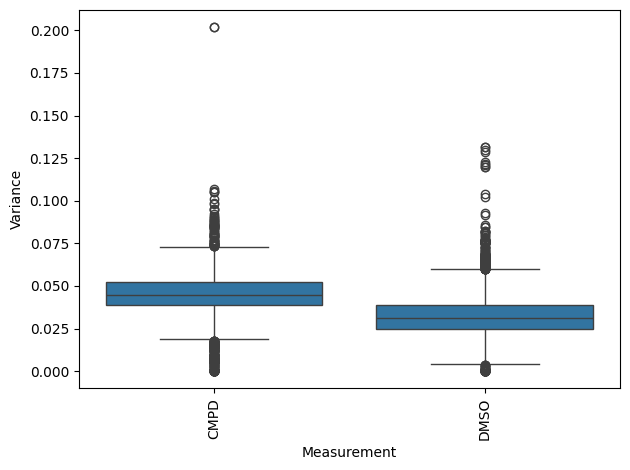

In [95]:

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

melted_variances_df = variances_df.reset_index().melt(id_vars='index', var_name='Measurement', value_name='Variance')
plt.figure()
sns.boxplot(x='Measurement', y='Variance', data=melted_variances_df)
plt.xticks(rotation=90)
plt.ylabel('Variance')
plt.xlabel('Measurement')
plt.tight_layout()
plt.show()

In [96]:
df = df[df["Metadata_cmpd_or_control"] == CMPD_or_DMSO]

In [97]:
# Function to rank concentrations within each treatment
def rank_within_treatment(group):
    # Rank the unique concentrations and map them back to the original values
    unique_concentrations = group["Metadata_Concentration"].unique()
    concentration_rank = {
        val: rank for rank, val in enumerate(sorted(unique_concentrations), start=1)
    }
    group["Metadata_Concentration"] = group["Metadata_Concentration"].map(
        concentration_rank
    )
    return group


# Apply the ranking function to each treatment group
#df = df.groupby("Metadata_Treatment").apply(rank_within_treatment)

In [98]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from scipy.spatial import distance

col_dict = {}
meta_cols = [col for col in df.columns if col.startswith("Metadata_")]
measurement_cols = [col for col in df.columns if not col.startswith("Metadata_")]
col_dict["Principal Components"] = []
col_dict["Most variance per channel"] = []
all_cols = set(meta_cols)
channels = [
    "All",
    "_ER",
    "_AGP",
    "_Mito",
    "_RNA",
    "_DNA",
    "Cells",
    "Cytoplasm",
    "Image",
    "Nuclei",
]

numerical_cols = df.select_dtypes(include=["float64", "int64"]).columns
most_var_cols = df[numerical_cols].var().nlargest(20).index.tolist()
col_dict["Most variance overall"] = most_var_cols

dmso_data = df[df["Metadata_Treatment"] == "DMSO"]
treatment_data = df[df["Metadata_Treatment"] != "DMSO"]

for channel in channels:
    if channel == "All":
        channel_cols = measurement_cols
    else:
        channel_cols = [col for col in df.columns if channel in col]
    channel = channel.replace("_", "")
    all_cols.update(channel_cols)
    most_var_cols = df[channel_cols].var().nlargest(5).index.tolist()
    col_dict["Most variance per channel"].extend(most_var_cols)

    # Perform PCA
    embedding = PCA(n_components=2).fit_transform(df[channel_cols])

    # MinMax scale the PCA components
    scaler = MinMaxScaler()
    embedding = scaler.fit_transform(embedding)

    df[f"{channel}_PC1"] = embedding[:, 0]
    df[f"{channel}_PC2"] = embedding[:, 1]

    col_dict["Principal Components"].extend([f"{channel}_PC1", f"{channel}_PC2"])

    # Calculate Mahalanobis distance within each Metadata_plate
    for plate, group in treatment_data.groupby("Metadata_Plate"):
        # Calculate the covariance matrix of the DMSO data for the current plate
        plate_dmso_data = dmso_data[dmso_data["Metadata_Plate"] == plate]
        if len(plate_dmso_data) > 1:  # Ensure there are enough samples
            epsilon = 1e-5  # Small constant for stabilization
            cov_matrix = np.cov(plate_dmso_data[channel_cols].T) + np.eye(len(channel_cols)) * epsilon
            inv_cov_matrix = np.linalg.inv(cov_matrix)

            # Calculate the mean of the DMSO data for the current plate
            mean_dms_data = np.mean(plate_dmso_data[channel_cols], axis=0)

            # Calculate Mahalanobis distance for each observation in the group
            df.loc[group.index, f'Mahalanobis Distance {channel}'] = group[channel_cols].apply(
                lambda x: distance.mahalanobis(x, mean_dms_data, inv_cov_matrix), axis=1
            )
        else:
            # If there's only one observation, set distance to NaN or handle accordingly
            df.loc[group.index, f'Mahalanobis Distance {channel}'] = np.nan

remaining_cols = [col for col in df.columns if col not in all_cols]

In [99]:
mahanolobis_cols = [
    col for col in df.columns if "Mahalanobis" in col
]

In [100]:
import numpy as np
from scipy.spatial import distance

# Assuming channel_cols is defined as in your code
channel_cols = [col for col in df.columns if any(ch in col for ch in channels)]



In [101]:
metadata_cp = [
    #'Metadata_Site_Count',
    # "Metadata_Count_Cells",
    # "Metadata_Count_CellsIncludingEdges",
    # "Metadata_Count_Cytoplasm",
    # "Metadata_Count_Nuclei",
    # "Metadata_Count_NucleiIncludingEdges",
    "Metadata_Count_Cells",
]
df["Metadata_Treatment_concentration"] = (
    df["Metadata_Treatment"] + "_" + df["Metadata_Concentration"].astype(str)
)

metadata_exp = [
    "Metadata_Treatment",
    "Metadata_Concentration",
    # "Metadata_Treatment_concentration",
]
remaining_cols = set(meta_cols) - set(metadata_cp) - set(metadata_exp)
remaining_cols = list(remaining_cols)
measurement_cols = [col for col in numerical_cols if "Metadata_" not in col]

In [102]:
# df = df[df["Metadata_Treatment_concentration"] == "DMSO_0.0"]
# df = df[df["Metadata_Plate"].isin(dmso_plates)]

In [103]:
from itertools import product

metadata_plate_effects_categorical = [
    #'Metadata_Plate',
    #'Metadata_plate_quantiles_2',
    #'Metadata_plate_quantiles_4',
    #'Metadata_plate_quantiles_8',
]
metadata_plate_effects_regression = [
    "Metadata_well_col_distance_to_edge",
    "Metadata_well_row_distance_to_edge",
    "Metadata_Ring_position",
]

metadata_plate_effects_categorical = [
    #"Metadata_Inside_outside",
    "Metadata_Plate",
    "Metadata_Week",
    "Metadata_Confocal_or_Nonconfocal",
]

metadata_plate_effects = (
    metadata_plate_effects_categorical + metadata_plate_effects_regression
)

cols_of_interest = [col for sublist in col_dict.values() for col in sublist]
cols_of_interest = list(set(cols_of_interest) - set(metadata_exp))
cols_of_interest = list(set(cols_of_interest) - set(metadata_plate_effects))
cols_of_interest = [col for col in cols_of_interest if not col.startswith("Metadata_")]
cols_of_interest += metadata_cp
metadata_pairs = list(product(metadata_plate_effects, cols_of_interest))

pcs_and_meta = metadata_cp
plate_pcs = list(product(metadata_plate_effects, pcs_and_meta))

In [104]:
import matplotlib.pyplot as plt
import seaborn as sns

plot_over_the_PCA = (
    metadata_exp
    + metadata_cp
    + metadata_plate_effects_regression
    + metadata_plate_effects_categorical
)

embedder = PCA(n_components=2).fit_transform(df[metadata_cp + measurement_cols])
df["All_PC1"] = embedder[:, 0]
df["All_PC2"] = embedder[:, 1]
# embedder = PCA(n_components=2).fit_transform(df[metadata_cp])
# df["Cell_descriptor_PC1"] = embedder[:, 0]
# df["Cell_descriptor_PC2"] = embedder[:, 1]

all_pcs = sorted([col for col in df.columns if "_PC" in col])
pc_pairs = list(zip(all_pcs[::2], all_pcs[1::2]))

In [105]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import silhouette_score
from statsmodels.formula.api import ols
from tqdm import tqdm


def quantify_confounding_effects(
    df, pc_pairs, confounding_factors, output_dir="figures"
):
    """
    Quantify and rank confounding effects on principal components using multiple methods.

    Parameters:
    -----------
    df : pandas DataFrame
        DataFrame containing the PC columns and confounding factors
    pc_pairs : list of tuples
        List of (PC1, PC2) column name pairs to analyze
    confounding_factors : list
        List of column names for potential confounding factors
    output_dir : str
        Directory to save output figures

    Returns:
    --------
    dict
        Dictionary containing all analysis results
    """
    print("Analyzing confounding effects on principal components...")

    # Create output directory if it doesn't exist
    import os

    os.makedirs(output_dir, exist_ok=True)

    results = {}

    # 1. ANOVA-based approach
    print("Running ANOVA analysis...")
    effect_sizes = calculate_effect_size(df, pc_pairs, confounding_factors)
    results["anova"] = effect_sizes

    # 2. Mutual Information approach
    print("Calculating mutual information...")
    mi_scores = calculate_mutual_info(df, pc_pairs, confounding_factors)
    results["mutual_info"] = mi_scores

    # 3. Clustering quality approach
    print("Evaluating clustering quality...")
    clustering_quality = calculate_clustering_quality(df, pc_pairs, confounding_factors)
    results["clustering"] = clustering_quality

    # 4. Combined ranking
    print("Creating combined ranking...")
    combined_ranking = create_combined_ranking(
        effect_sizes, mi_scores, clustering_quality
    )
    results["combined"] = combined_ranking

    # 5. Visualizations
    print("Generating visualizations...")
    create_visualizations(
        effect_sizes, mi_scores, clustering_quality, combined_ranking, output_dir
    )

    print(f"Analysis complete. Visualizations saved to {output_dir}/")
    return results


def calculate_effect_size(df, pc_pairs, confounding_factors):
    """Calculate effect size using ANOVA"""
    results = []

    for pc1, pc2 in tqdm(pc_pairs, desc="ANOVA analysis"):
        for factor in confounding_factors:
            # Skip if the factor has too many unique values
            if df[factor].nunique() > 100:
                continue

            try:
                # PC1 analysis
                model = ols(f"{pc1} ~ C({factor})", data=df).fit()
                aov_table = sm.stats.anova_lm(model, typ=2)
                r_squared_pc1 = model.rsquared
                f_value_pc1 = aov_table["F"].iloc[0]
                p_value_pc1 = aov_table["PR(>F)"].iloc[0]

                # PC2 analysis
                model = ols(f"{pc2} ~ C({factor})", data=df).fit()
                aov_table = sm.stats.anova_lm(model, typ=2)
                r_squared_pc2 = model.rsquared
                f_value_pc2 = aov_table["F"].iloc[0]
                p_value_pc2 = aov_table["PR(>F)"].iloc[0]

                # Combined effect (average of PC1 and PC2)
                combined_r_squared = (r_squared_pc1 + r_squared_pc2) / 2

                results.append(
                    {
                        "PC_Pair": f"{pc1}-{pc2}",
                        "Factor": factor.replace("Metadata_", ""),
                        "R_squared_PC1": r_squared_pc1,
                        "R_squared_PC2": r_squared_pc2,
                        "Combined_R_squared": combined_r_squared,
                        "F_value_PC1": f_value_pc1,
                        "P_value_PC1": p_value_pc1,
                        "F_value_PC2": f_value_pc2,
                        "P_value_PC2": p_value_pc2,
                        "Significant_PC1": p_value_pc1 < 0.05,
                        "Significant_PC2": p_value_pc2 < 0.05,
                    }
                )
            except Exception as e:
                print(f"Could not analyze {factor} for {pc1}-{pc2}: {e}")

    return pd.DataFrame(results)


def calculate_mutual_info(df, pc_pairs, confounding_factors):
    """Calculate mutual information between factors and PCs"""
    results = []

    for pc1, pc2 in tqdm(pc_pairs, desc="Mutual information"):
        for factor in confounding_factors:
            try:
                # Convert categorical to numeric if needed
                if df[factor].dtype == "object" or df[factor].dtype.name == "category":
                    factor_encoded = pd.factorize(df[factor])[0]
                else:
                    factor_encoded = df[factor].values

                # Calculate mutual information
                mi_pc1 = mutual_info_regression(factor_encoded.reshape(-1, 1), df[pc1])[
                    0
                ]
                mi_pc2 = mutual_info_regression(factor_encoded.reshape(-1, 1), df[pc2])[
                    0
                ]
                combined_mi = (mi_pc1 + mi_pc2) / 2

                results.append(
                    {
                        "PC_Pair": f"{pc1}-{pc2}",
                        "Factor": factor.replace("Metadata_", ""),
                        "MI_PC1": mi_pc1,
                        "MI_PC2": mi_pc2,
                        "Combined_MI": combined_mi,
                    }
                )
            except Exception as e:
                print(f"Error with {factor}: {e}")

    return pd.DataFrame(results)


def calculate_clustering_quality(df, pc_pairs, confounding_factors):
    """Calculate clustering quality using silhouette score"""
    results = []

    for pc1, pc2 in tqdm(pc_pairs, desc="Clustering quality"):
        pc_data = df[[pc1, pc2]].values

        for factor in confounding_factors:
            try:
                # Skip if too many unique values or not categorical
                if df[factor].nunique() > 100 or df[factor].nunique() < 2:
                    continue

                labels = df[factor].astype("category").cat.codes.values

                # Calculate silhouette score
                if len(np.unique(labels)) > 1:  # Need at least 2 clusters
                    sil_score = silhouette_score(pc_data, labels, metric="euclidean")

                    results.append(
                        {
                            "PC_Pair": f"{pc1}-{pc2}",
                            "Factor": factor.replace("Metadata_", ""),
                            "Silhouette_Score": sil_score,
                        }
                    )
            except Exception as e:
                print(f"Error with {factor}: {e}")

    return pd.DataFrame(results)


def create_combined_ranking(effect_sizes, mi_scores, clustering_quality):
    """Combine all metrics into a final ranking"""
    # Normalize each metric to 0-1 scale
    for df, metric in [
        (effect_sizes, "Combined_R_squared"),
        (mi_scores, "Combined_MI"),
        (clustering_quality, "Silhouette_Score"),
    ]:
        if not df.empty:
            for pc_pair in df["PC_Pair"].unique():
                mask = df["PC_Pair"] == pc_pair
                min_val = df.loc[mask, metric].min()
                max_val = df.loc[mask, metric].max()
                if max_val > min_val:
                    df.loc[mask, f"Normalized_{metric}"] = (
                        df.loc[mask, metric] - min_val
                    ) / (max_val - min_val)
                else:
                    df.loc[mask, f"Normalized_{metric}"] = 0

    # Combine all metrics
    combined = []

    for pc_pair in effect_sizes["PC_Pair"].unique():
        factors = effect_sizes[effect_sizes["PC_Pair"] == pc_pair]["Factor"].unique()

        for factor in factors:
            combined_score = 0
            count = 0

            # Add ANOVA score
            es_row = effect_sizes[
                (effect_sizes["PC_Pair"] == pc_pair)
                & (effect_sizes["Factor"] == factor)
            ]
            if not es_row.empty:
                combined_score += es_row["Normalized_Combined_R_squared"].values[0]
                count += 1

            # Add MI score
            mi_row = mi_scores[
                (mi_scores["PC_Pair"] == pc_pair) & (mi_scores["Factor"] == factor)
            ]
            if not mi_row.empty:
                combined_score += mi_row["Normalized_Combined_MI"].values[0]
                count += 1

            # Add clustering score
            cl_row = clustering_quality[
                (clustering_quality["PC_Pair"] == pc_pair)
                & (clustering_quality["Factor"] == factor)
            ]
            if not cl_row.empty:
                combined_score += cl_row["Normalized_Silhouette_Score"].values[0]
                count += 1

            if count > 0:
                combined.append(
                    {
                        "PC_Pair": pc_pair,
                        "Factor": factor,
                        "Combined_Score": combined_score / count,
                    }
                )

    return pd.DataFrame(combined)


def create_visualizations(
    effect_sizes, mi_scores, clustering_quality, combined_ranking, output_dir
):
    """Create visualizations for all metrics"""
    # 1. ANOVA heatmap
    if not effect_sizes.empty:
        pivot_table = effect_sizes.pivot_table(
            index="Factor", columns="PC_Pair", values="Combined_R_squared"
        )

        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, cmap="viridis", fmt=".2f")
        plt.title("Effect Size (R²) of Confounding Factors on PC Pairs")
        plt.tight_layout()
        plt.savefig(
            f"figures/{CMPD_or_DMSO}/confounding_factors_anova_heatmap.png",
            dpi=100,
            bbox_inches="tight",
        )
        plt.close()

        # Bar plot for average effect
        avg_effects = (
            effect_sizes.groupby("Factor")["Combined_R_squared"]
            .mean()
            .sort_values(ascending=False)
        )

        plt.figure(figsize=(12, 6))
        sns.barplot(x=avg_effects.index, y=avg_effects.values)
        plt.xticks(rotation=45, ha="right")
        plt.title("Average Effect Size (R²) of Confounding Factors Across All PC Pairs")
        plt.tight_layout()
        plt.savefig(
            f"figures/{CMPD_or_DMSO}/confounding_factors_anova_ranking.png",
            dpi=100,
            bbox_inches="tight",
        )
        plt.close()

    # 2. Mutual Information heatmap
    if not mi_scores.empty:
        pivot_table = mi_scores.pivot_table(
            index="Factor", columns="PC_Pair", values="Combined_MI"
        )

        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, cmap="viridis", fmt=".2f")
        plt.title("Mutual Information Between Confounding Factors and PC Pairs")
        plt.tight_layout()
        plt.savefig(
            f"figures/{CMPD_or_DMSO}/confounding_factors_mi_heatmap.png",
            dpi=100,
            bbox_inches="tight",
        )
        plt.close()

    # 3. Clustering quality heatmap
    if not clustering_quality.empty:
        pivot_table = clustering_quality.pivot_table(
            index="Factor", columns="PC_Pair", values="Silhouette_Score"
        )

        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, cmap="viridis", fmt=".2f")
        plt.title(
            "Clustering Quality (Silhouette Score) of Confounding Factors on PC Pairs"
        )
        plt.tight_layout()
        plt.savefig(
            f"figures/{CMPD_or_DMSO}/confounding_factors_clustering_heatmap.png",
            dpi=100,
            bbox_inches="tight",
        )
        plt.close()

    # 4. Combined ranking heatmap
    if not combined_ranking.empty:
        pivot_table = combined_ranking.pivot_table(
            index="Factor", columns="PC_Pair", values="Combined_Score"
        )

        plt.figure(figsize=(12, 8))
        sns.heatmap(pivot_table, annot=True, cmap="viridis", fmt=".2f")
        plt.title("Combined Effect of Confounding Factors on PC Pairs")
        plt.tight_layout()
        plt.savefig(
            f"figures/{CMPD_or_DMSO}confounding_factors_combined_heatmap.png",
            dpi=100,
            bbox_inches="tight",
        )
        plt.close()

        # Bar plot for average combined effect
        avg_effects = (
            combined_ranking.groupby("Factor")["Combined_Score"]
            .mean()
            .sort_values(ascending=False)
        )

        plt.figure(figsize=(12, 6))
        sns.barplot(x=avg_effects.index, y=avg_effects.values)
        plt.xticks(rotation=45, ha="right")
        plt.title("Average Combined Effect of Confounding Factors Across All PC Pairs")
        plt.tight_layout()
        plt.savefig(
            f"figures/{CMPD_or_DMSO}confounding_factors_combined_ranking.png",
            dpi=100,
            bbox_inches="tight",
        )
        plt.close()

In [106]:
# results = quantify_confounding_effects(df, pc_pairs, plot_over_the_PCA)

In [107]:
# for pc1, pc2 in tqdm(pc_pairs):
#     # Create a 4x4 grid of subplots
#     fig, axes = plt.subplots(3, 3, figsize=(20, 20))

#     # Flatten the axes array for easier indexing
#     axes = axes.flatten()

#     # Iterate over the pairs of principal components and the axes
#     for i, hue_col in enumerate(plot_over_the_PCA):
#         # Create the scatter plot
#         sns.scatterplot(
#             data=df,
#             x=pc1,
#             y=pc2,
#             hue=hue_col,
#             alpha=0.6,  # Increased transparency
#             ax=axes[i],
#             legend=False,
#         )

#         # Set the title for each subplot
#         title = hue_col.replace("Metadata_", "").replace("_", " ")
#         axes[i].set_title(title)

#         # Move the legend to a better location
#         # axes[i].legend(loc='upper right', bbox_to_anchor=(1.2, 1), title=hue_col)

#     # Adjust layout and spacing
#     plt.tight_layout(pad=3.0)  # Increase padding between subplots

#     # Overall title for the figure (optional)
#     # plt.suptitle("PCA Scatter Plots by Treatment Concentration", fontsize=16)

#     # Show the figure
#     # plt.show()
#     if CMPD_or_DMSO == "DMSO" or CMPD_or_DMSO == "CMPD":
#         subfolder = CMPD_or_DMSO
#     else:
#         subfolder = "cmpd_dmso_split"

#     plt.savefig(f"figures/{subfolder}_{pc1}_{pc2}.png", dpi=100, bbox_inches="tight")

#     # Close the plot to free memory
#     plt.close()

In [108]:
#df = df[df["Metadata_Concentration"] == df["Metadata_Concentration"].max()]

In [109]:
import math

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

if CMPD_or_DMSO == "CMPD":
    for pc1, pc2 in tqdm(pc_pairs):
        for categorical_effects in metadata_plate_effects_categorical:
            # print(f"Plotting {categorical_effects} for {pc1} and {pc2}")
            unique_cats = df[categorical_effects].nunique()
            rows = math.ceil(unique_cats / 3)  # Adjust the number of columns as needed
            cols = min(unique_cats, 3)  # Set a maximum number of columns
            fig, axes = plt.subplots(rows, cols, figsize=(15, 15))
            axes = axes.flatten()
            for i, cat in enumerate(df[categorical_effects].unique()):
                if i == 0:
                    legend = True
                else:
                    legend = False

                sns.scatterplot(
                    data=df[df[categorical_effects] == cat],
                    x=pc1,
                    y=pc2,
                    hue="Metadata_Treatment",
                    style="Metadata_Concentration",
                    palette="Set1",
                    ax=axes[i],
                    legend=legend,
                )
                axes[i].set_title(f"{cat}")

            # Place legend outside the subplots
            handles, labels = axes[0].get_legend_handles_labels()
            fig.legend(
                handles,
                labels,
                loc="upper right",
                bbox_to_anchor=(1.1, 1),
                bbox_transform=fig.transFigure,
            )  # Adjust legend position
            axes[0].legend_.remove()  # Remove legend from the first subplot
            plt.suptitle(f"{categorical_effects}", fontsize=16)
            plt.tight_layout(
                rect=[0, 0, 0.85, 1]
            )  # Adjust layout to make space for the legend

            plt.savefig(
                f"figures/{CMPD_or_DMSO}_confounding_factors_{categorical_effects}_{pc1}_{pc2}.png",
                dpi=150,
                bbox_inches="tight",
            )
            plt.close()

100%|██████████| 10/10 [01:01<00:00,  6.15s/it]


In [110]:
only_pc1 = [
    "All_PC1",
    "AGP_PC1",
    "Cytoplasm_PC1",
    "DNA_PC1",
    "ER_PC1",
    "RNA_PC1",
    "Metadata_Count_Cells",
    "Metadata_Count_Nuclei",
]

In [111]:
for effect in [
    "Metadata_Inside_outside",
    "Metadata_Plate",
    "Metadata_Week",
    "Metadata_Confocal_or_Nonconfocal",
    "Metadata_Treatment",
]:
    g = sns.PairGrid(
        data=df,
        hue=effect,
        vars=only_pc1,
        corner=True,
        # alpha=0.5,
        palette="Set1",
        # x_vars = only_pc1,
        # y_vars = metadata_plate_effects,
    )
    g.map_lower(sns.scatterplot, alpha=0.5)
    g.map_diag(sns.kdeplot)
    g.add_legend()
    plt.savefig(
        f"figures/{CMPD_or_DMSO}_confounding_factors_scatter_{effect}.png",
        dpi=150,
        bbox_inches="tight",
    )
    # plt.show()
    plt.close()

In [112]:
df.reset_index(drop=True, inplace=True)

In [113]:
import pandas as pd
from statsmodels.stats.anova import anova_lm
from tqdm import tqdm

# Initialize results lists
statistical_results = []
constant_cols = []

# Define your confounding variables
confounders = [
    "Metadata_Plate",
    "Metadata_Treatment",
    #"Metadata_Concentration",
]  # Replace with actual column names

# Group the DataFrame by treatment concentration to avoid filtering repeatedly
# only_highest_conc = df[df["Metadata_Concentration"] == df["Metadata_Concentration"].max()].copy()
grouped_df = df.groupby("Metadata_Treatment")

# Outer loop with tqdm
for treat_conc, filtered_df in tqdm(
    grouped_df, desc="Processing treatment concentrations"
):
    # Inner loop with tqdm
    for x, y in tqdm(
        metadata_pairs, desc=f"Processing metadata pairs for {treat_conc}", leave=False
    ):
        try:
            # Skip if there's not enough variation in the predictor
            if filtered_df[x].nunique() <= 1:
                constant_cols.append(
                    (treat_conc, x, y, "Not enough variation in predictor")
                )
                continue

            # Skip if there's not enough variation in the outcome
            if filtered_df[y].nunique() <= 1:
                constant_cols.append(
                    (treat_conc, x, y, "Not enough variation in outcome")
                )
                continue

            # Create a list of valid confounders (those present in the DataFrame)
            valid_confounders = [
                conf
                for conf in confounders
                if conf in filtered_df.columns and filtered_df[conf].nunique() > 1
            ]

            # Determine if we're dealing with a categorical predictor
            is_categorical = x in metadata_plate_effects_categorical

            if is_categorical:
                # ANCOVA approach for categorical predictors
                formula = f"{y} ~ C({x})"
                for conf in valid_confounders:
                    if pd.api.types.is_numeric_dtype(filtered_df[conf]):
                        formula += f" + {conf}"
                    else:
                        formula += f" + C({conf})"

                model = ols(formula, data=filtered_df).fit()
                anova_table = anova_lm(model)

                # Extract results for the predictor of interest
                if f"C({x})" in anova_table.index:
                    f_statistic = anova_table.loc[f"C({x})", "F"]
                    p_value = anova_table.loc[f"C({x})", "PR(>F)"]
                    effect_size = np.sqrt(
                        f_statistic
                        * (len(filtered_df[x].unique()) - 1)
                        / (
                            f_statistic * (len(filtered_df[x].unique()) - 1)
                            + model.df_resid
                        )
                    )  # Partial eta squared

                    statistical_results.append(
                        {
                            "treatment_conc": treat_conc,
                            "predictor": x,
                            "outcome": y,
                            "method": "ANCOVA",
                            "f_statistic": f_statistic,
                            "p_value": p_value,
                            "effect_size": effect_size,
                            "r_squared": model.rsquared,
                            "confounders": valid_confounders,
                        }
                    )
                else:
                    constant_cols.append(
                        (treat_conc, x, y, "Predictor not found in ANOVA table")
                    )

            else:
                # Multiple regression approach for continuous predictors
                # Prepare the predictor variables including confounders
                predictors = [x] + valid_confounders

                # Convert categorical confounders to dummy variables if needed
                formula_parts = [x]
                for conf in valid_confounders:
                    if pd.api.types.is_numeric_dtype(filtered_df[conf]):
                        formula_parts.append(conf)
                    else:
                        formula_parts.append(f"C({conf})")

                formula = f"{y} ~ {' + '.join(formula_parts)}"
                model = ols(formula, data=filtered_df).fit()

                # Extract results for the predictor of interest
                x_index = (
                    model.params.index.get_loc(x) if x in model.params.index else None
                )
                if x_index is not None:
                    x_coef = model.params[x]
                    x_pvalue = model.pvalues[x]
                    x_stderr = model.bse[x]

                    statistical_results.append(
                        {
                            "treatment_conc": treat_conc,
                            "predictor": x,
                            "outcome": y,
                            "method": "Regression",
                            "coefficient": x_coef,
                            "std_error": x_stderr,
                            "p_value": x_pvalue,
                            "r_squared": model.rsquared,
                            "confounders": valid_confounders,
                        }
                    )
                else:
                    constant_cols.append(
                        (treat_conc, x, y, "Predictor not found in regression results")
                    )

        except Exception as e:
            constant_cols.append((treat_conc, x, y, str(e)))

# Convert results to DataFrame for easier analysis
results_df = pd.DataFrame(statistical_results)
constant_cols_df = pd.DataFrame(
    constant_cols, columns=["treatment_conc", "predictor", "outcome", "error"]
)

Processing treatment concentrations:   0%|          | 0/4 [00:00<?, ?it/s]

Processing treatment concentrations: 100%|██████████| 4/4 [00:24<00:00,  6.03s/it]


In [114]:
# Apply Bonferroni correction
results_df["adjusted_p_value"] = results_df["p_value"].fillna(1) * len(results_df)

# Ensure adjusted p-values do not exceed 1
results_df["adjusted_p_value"] = results_df["adjusted_p_value"].clip(upper=1)

results_df.sort_values(by="adjusted_p_value", ascending=True, inplace=True)

results_df["Rank"] = results_df["adjusted_p_value"].rank(method="first").astype(int)

results_df.to_csv("significance_results.csv", index=False)

In [115]:
top_plate_effects = results_df.head(20)
pc_and_meta_plate_effects = results_df[results_df["outcome"].isin(only_pc1)].head(
    20
)

In [116]:
all_meta = df.columns[df.columns.str.startswith("Metadata_")].tolist()

In [117]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder

max_row = df["Metadata_Well_row"].max() + 1
max_col = df["Metadata_Well_col"].max() + 1


def plot_plate(row_sig_test, treat_conc, filtered_df):
    x = row_sig_test["predictor"]
    y = row_sig_test["outcome"]
    adjusted_p = row_sig_test["adjusted_p_value"]
    rank = row_sig_test["Rank"]

    # Prepare position data
    if pd.api.types.is_numeric_dtype(filtered_df[x]):
        mask_position = filtered_df[x].to_list()
    else:
        le = LabelEncoder()
        mask_position = le.fit_transform(filtered_df[x])

    values = filtered_df[y].to_list()

    # Initialize masks
    position_mask = np.full((max_row, max_col), np.nan)
    value_mask = np.full((max_row, max_col), np.nan)
    treatment_mask = np.full((max_row, max_col), np.nan)
    concentration_mask = np.full((max_row, max_col), np.nan)
    stddev_mask = np.full((max_row, max_col), np.nan)
    cv_mask = np.full(
        (max_row, max_col), np.nan
    )  # New mask for coefficient of variation

    # Create mappings for categorical data
    unique_treatments = filtered_df["Metadata_Treatment"].unique()
    treatment_map = {t: i for i, t in enumerate(unique_treatments)}

    unique_concentrations = filtered_df["Metadata_Concentration"].unique()
    concentration_map = {c: i for i, c in enumerate(unique_concentrations)}

    # Populate masks
    for i, row in filtered_df.iterrows():
        r = int(row["Metadata_Well_row"])
        c = int(row["Metadata_Well_col"])
        idx = i % len(mask_position)  # Prevent index errors

        position_mask[r, c] = mask_position[idx]
        value_mask[r, c] = values[idx]
        treatment_mask[r, c] = treatment_map[row["Metadata_Treatment"]]
        concentration_mask[r, c] = concentration_map[row["Metadata_Concentration"]]

    # Calculate median for each well position
    grouped_df_median = (
        filtered_df.groupby(["Metadata_Well_row", "Metadata_Well_col"])[y]
        .median()
        .reset_index()
    )
    for _, row in grouped_df_median.iterrows():
        r = int(row["Metadata_Well_row"])
        c = int(row["Metadata_Well_col"])
        value_mask[r, c] = row[y]

    # Calculate standard deviation for each well position
    grouped_df_stddev = (
        filtered_df.groupby(["Metadata_Well_row", "Metadata_Well_col"])[y]
        .std()
        .reset_index()
    )
    for _, row in grouped_df_stddev.iterrows():
        r = int(row["Metadata_Well_row"])
        c = int(row["Metadata_Well_col"])
        stddev_mask[r, c] = row[y]

    # Calculate coefficient of variation for each well position
    grouped_df_cv = (
        filtered_df.groupby(["Metadata_Well_row", "Metadata_Well_col"])[y]
        .agg(["mean", "std"])
        .reset_index()
    )
    grouped_df_cv["cv"] = grouped_df_cv["std"] / grouped_df_cv["mean"]
    for _, row in grouped_df_cv.iterrows():
        r = int(row["Metadata_Well_row"])
        c = int(row["Metadata_Well_col"])
        cv_mask[r, c] = row["cv"]

    # Create figure layout
    fig = plt.figure(figsize=(24, 12))  # Adjusted figure size
    gs = gridspec.GridSpec(
        2, 3, height_ratios=[1, 1], width_ratios=[1, 1, 1]
    )  # Two rows, three columns

    axes = [
        plt.subplot(gs[0, 0]),
        plt.subplot(gs[0, 1]),
        plt.subplot(gs[0, 2]),
        plt.subplot(gs[1, 0]),
        plt.subplot(gs[1, 1]),
        plt.subplot(gs[1, 2]),
    ]  # Adjusted for 2x3 layout

    # Plot heatmaps
    sns.heatmap(position_mask, cmap="Set2", cbar=True, ax=axes[2])
    axes[2].set_title(f"Positions of {x}")
    axes[2].axis("off")

    sns.heatmap(value_mask, cmap="viridis", cbar=True, ax=axes[1])
    axes[1].set_title(f"Median value of {y}")
    axes[1].axis("off")

    # Treatment heatmap with legend - using updated colormap approach
    cmap_treat = plt.colormaps["Dark2"].resampled(len(unique_treatments))
    sns.heatmap(treatment_mask, cmap=cmap_treat, cbar=False, ax=axes[0])
    axes[0].set_title("Treatment")
    axes[0].axis("off")

    # Add treatment legend
    treatment_patches = [
        mpatches.Patch(color=cmap_treat(i), label=t)
        for i, t in enumerate(unique_treatments)
    ]
    axes[0].legend(
        handles=treatment_patches,
        title="Treatments",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    # Concentration heatmap
    cmap_conc = plt.colormaps["plasma"].resampled(len(unique_concentrations))
    sns.heatmap(concentration_mask, cmap=cmap_conc, cbar=False, ax=axes[3])
    axes[3].set_title("Concentration")
    axes[3].axis("off")

    # Add concentration legend
    concentration_patches = [
        mpatches.Patch(color=cmap_conc(i), label=str(c))
        for i, c in enumerate(unique_concentrations)
    ]
    axes[3].legend(
        handles=concentration_patches,
        title="Concentrations",
        bbox_to_anchor=(1.05, 1),
        loc="upper left",
    )

    # Coefficient of Variation heatmap
    sns.heatmap(cv_mask, cmap="coolwarm", cbar=True, ax=axes[4])
    axes[4].set_title(f"Coefficient of Variation of {y}")
    axes[4].axis("off")

    # Violin plot
    sorted_x_values = sorted(filtered_df[x].unique())
    sns.violinplot(data=filtered_df, x=x, y=y, cut=0, ax=axes[5], order=sorted_x_values)
    # Format labels
    x_label = x.replace("_", " ").replace("Metadata_", "")
    y_label = y.replace("_", " ").replace("Metadata_", "")

    axes[5].set_title(f"Adjusted p-value: {adjusted_p:.2e}")
    axes[5].set_xlabel(x_label)
    axes[5].set_ylabel(y_label)

    # Set x-tick labels
    unique_labels = filtered_df[x].unique()
    axes[5].set_xticks(
        range(len(unique_labels))
    )  # Set the ticks to correspond to the number of unique labels
    axes[5].set_xticklabels(
        unique_labels, rotation=45, ha="right"
    )  # Set the tick labels

    plt.tight_layout()

    if treat_conc == "DMSO" or treat_conc == "CMPD":
        subfolder = treat_conc
    else:
        subfolder = "cmpd_dmso_split"
    plt.savefig(
        f"figures/{subfolder}/Rank_{rank}__{adjusted_p:.2e}_{treat_conc}_{x}_{y}_.png",
        bbox_inches="tight",
    )
    plt.close()

In [118]:
# # Precompute the unique treatment concentrations and their corresponding filtered DataFrames
# grouped_data_DMSO_control = {
#     treat_conc: filtered_df
#     for treat_conc, filtered_df in df.groupby("Metadata_cmpd_or_control")
# }
# grouped_data_treat_conc = {
#     treat_conc: filtered_df
#     for treat_conc, filtered_df in df.groupby("Metadata_Treatment_concentration")
# }
# grouped_data_treat_conc2 = {
#     treat_conc: filtered_df
#     for treat_conc, filtered_df in df.groupby("Metadata_Treatment_concentration")
# }

In [119]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder

max_row = df["Metadata_Well_row"].max() + 1
max_col = df["Metadata_Well_col"].max() + 1

def plot_heatmap_with_std(row_sig_test, filtered_df):
    x = row_sig_test["predictor"]
    y = row_sig_test["outcome"]
    adjusted_p = row_sig_test["adjusted_p_value"]

    # Prepare position data
    if pd.api.types.is_numeric_dtype(filtered_df[x]):
        le = LabelEncoder()
        mask_position = filtered_df[x].to_list()
    else:
        le = LabelEncoder()
        mask_position = le.fit_transform(filtered_df[x])

    values = filtered_df[y].to_list()

    # Initialize masks
    position_mask = np.full((max_row, max_col), np.nan)
    value_mask = np.full((max_row, max_col), np.nan)
    stddev_mask = np.full((max_row, max_col), np.nan)

    # Populate masks
    for i, row in filtered_df.iterrows():
        r = int(row["Metadata_Well_row"])
        c = int(row["Metadata_Well_col"])
        idx = i % len(mask_position)  # Prevent index errors

        position_mask[r, c] = mask_position[idx]
        value_mask[r, c] = values[idx]

    # Calculate standard deviation for each well position
    grouped_df_stddev = (
        filtered_df.groupby(["Metadata_Well_row", "Metadata_Well_col"])[y]
        .std()
        .reset_index()
    )
    for _, row in grouped_df_stddev.iterrows():
        r = int(row["Metadata_Well_row"])
        c = int(row["Metadata_Well_col"])
        stddev_mask[r, c] = row[y]

    # Create figure layout
    fig = plt.figure(figsize=(14, 6))  # Adjusted figure size
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])  # One row, two columns

    axes = [
        plt.subplot(gs[0, 0]),
        plt.subplot(gs[0, 1]),
    ]  # Adjusted for 1x2 layout

    # Plot heatmaps
    sns.heatmap(value_mask, cmap="viridis", cbar=True, ax=axes[0])
    axes[0].set_title(f"Values of {y}")
    axes[0].axis("off")

    sns.heatmap(stddev_mask, cmap="coolwarm", cbar=True, ax=axes[1])
    axes[1].set_title(f"Standard Deviation of {y}")
    axes[1].axis("off")

    plt.tight_layout()
    plt.savefig(
        f"figures/plate_plot_{y}.png",
        bbox_inches="tight",
    )
    plt.close()

In [120]:
# # Iterate over the top plate effects and generate violin plots
# for i, row in tqdm(
#     pc_and_meta_plate_effects.iterrows(),
#     desc="Processing metadata pairs",
#     total=len(pc_and_meta_plate_effects),
# ):
#     #if row["Rank"] > 100:
#     #    continue
#     for i, (treat_conc, filtered_df) in enumerate(grouped_data_DMSO_control.items()):
#         plot_plate(row, treat_conc, filtered_df)
#         if i == 0:
#             plot_heatmap_with_std(row, filtered_df)
        

In [121]:
# # Iterate over the top plate effects and generate violin plots
# if CMPD_or_DMSO == "CMPD":
#     for i, row in tqdm(
#         pc_and_meta_plate_effects.iterrows(),
#         desc="Processing metadata pairs",
#         total=len(pc_and_meta_plate_effects),
#     ):
#         if row["Rank"] > 100:
#             continue
#         for treat_conc, filtered_df in grouped_data_treat_conc.items():
#             plot_plate(row, treat_conc, filtered_df)

In [122]:
# # Iterate over the top plate effects and generate violin plots
# for i, row in tqdm(pc_and_meta_plate_effects.iterrows(), desc="Processing metadata pairs", total = len(pc_and_meta_plate_effects)):
#     for treat_conc, filtered_df in grouped_data_treat_conc.items():
#         plot_plate(row, treat_conc, filtered_df)

In [123]:
# # # Iterate over the top plate effects and generate violin plots
# for i, row in tqdm(
#     top_plate_effects.iterrows(),
#     desc="Processing metadata pairs",
#     total=len(top_plate_effects),
# ):
#     if row["Rank"] > 100:
#         continue
#     for treat_conc, filtered_df in grouped_data_treat_conc2.items():
#         plot_plate(row, treat_conc, filtered_df)

In [124]:
# Print the results
# Generate the violin plot

In [125]:
# # Define a function to process each treatment concentration with its metadata pairs
# def process_treatment(treat_conc):
#     for pair in metadata_pairs:
#         violinplot(pair, treat_conc, df)


# # Use the unique treatment concentrations and apply the processing function
# df["Metadata_Treatment_concentration"].unique().map(process_treatment)

In [126]:
metadata_cols = [col for col in df.columns if col.startswith("Metadata_")]
measurement_cols = [col for col in df.columns if not col.startswith("Metadata_")]

# Select the 1000 measurement columns with the highest variance
top_measurement_cols = df[measurement_cols].var().nlargest(1000).index.tolist()
measurement_cols = top_measurement_cols
#df = df[metadata_cols + measurement_cols]

In [127]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.stats.multitest as multi
from joblib import Parallel, delayed
from sklearn.decomposition import PCA
from statsmodels.formula.api import ols
from tqdm import tqdm

# Suppress warnings
warnings.filterwarnings("ignore")


def filter_columns_by_variance(df, threshold=0.01):
    """Filter out columns with variance below the threshold."""
    measurement_cols = [col for col in df.columns if not col.startswith("Metadata_")]
    variances = df[measurement_cols].var()
    filtered_cols = variances[variances > threshold].index.tolist()
    return df[
        filtered_cols + [col for col in df.columns if col.startswith("Metadata_")]
    ]


def analyze_position_effects(df_control):
    """Analyze position effects using only the DMSO control data"""

    metadata_cols = [col for col in df_control.columns if col.startswith("Metadata_")]
    measurement_cols = [
        col for col in df_control.columns if not col.startswith("Metadata_")
    ]

    position_effects = []

    for measure in tqdm(measurement_cols, desc="Analyzing position effects"):
        temp_df = df_control.copy()
        temp_df["y"] = temp_df[measure]
        model_row = ols("y ~ C(Metadata_well_row_distance_to_edge)", data=temp_df).fit()
        anova_row = sm.stats.anova_lm(model_row, typ=2)
        p_value_row = anova_row.loc["C(Metadata_well_row_distance_to_edge)", "PR(>F)"]

        model_col = ols("y ~ C(Metadata_well_col_distance_to_edge)", data=temp_df).fit()
        anova_col = sm.stats.anova_lm(model_col, typ=2)
        p_value_col = anova_col.loc["C(Metadata_well_col_distance_to_edge)", "PR(>F)"]

        ss_total_row = model_row.ssr + model_row.ess
        eta_squared_row = model_row.ssr / ss_total_row

        ss_total_col = model_col.ssr + model_col.ess
        eta_squared_col = model_col.ssr / ss_total_col

        position_effects.append(
            {
                "measurement": measure,
                "p_value_row": p_value_row,
                "p_value_col": p_value_col,
                "eta_squared_row": eta_squared_row,
                "eta_squared_col": eta_squared_col,
            }
        )

    position_df = pd.DataFrame(position_effects)
    position_df["p_adj_row"] = multi.fdrcorrection(position_df["p_value_row"])[1]
    position_df["p_adj_col"] = multi.fdrcorrection(position_df["p_value_col"])[1]

    position_df["combined_effect"] = (
        position_df["eta_squared_row"] + position_df["eta_squared_col"]
    )
    position_df = position_df.sort_values("combined_effect", ascending=False)

    # Save intermediate results
    position_df.to_csv("position_effects.csv", index=False)

    return position_df


def analyze_plate_batch_effects(df_control):
    """Analyze batch effects between plates within the same week"""

    metadata_cols = [col for col in df_control.columns if col.startswith("Metadata_")]
    measurement_cols = [
        col for col in df_control.columns if not col.startswith("Metadata_")
    ]

    plate_effects = []

    for week in tqdm(
        df_control["Metadata_Week"].unique(), desc="Analyzing plate batch effects"
    ):
        week_data = df_control[df_control["Metadata_Week"] == week]

        for measure in measurement_cols:
            temp_df = week_data.copy()
            temp_df["y"] = temp_df[measure]

            model = ols("y ~ C(Metadata_Plate)", data=temp_df).fit()
            anova = sm.stats.anova_lm(model, typ=2)
            p_value = anova.loc["C(Metadata_Plate)", "PR(>F)"]

            ss_total = model.ssr + model.ess
            eta_squared = model.ssr / ss_total

            plate_effects.append(
                {
                    "measurement": measure,
                    "week": week,
                    "p_value": p_value,
                    "eta_squared": eta_squared,
                }
            )

    plate_df = pd.DataFrame(plate_effects)
    plate_df["p_adj"] = multi.fdrcorrection(plate_df["p_value"])[1]

    avg_effects = plate_df.groupby("measurement")["eta_squared"].mean().reset_index()
    avg_effects = avg_effects.sort_values("eta_squared", ascending=False)

    # Save intermediate results
    plate_df.to_csv("plate_effects.csv", index=False)

    return plate_df, avg_effects


def analyze_week_batch_effects(df_control):
    """Analyze batch effects between different weeks"""

    metadata_cols = [col for col in df_control.columns if col.startswith("Metadata_")]
    measurement_cols = [
        col for col in df_control.columns if not col.startswith("Metadata_")
    ]

    week_effects = []

    for measure in tqdm(measurement_cols, desc="Analyzing week batch effects"):
        temp_df = df_control.copy()
        temp_df["y"] = temp_df[measure]

        model = ols("y ~ C(Metadata_Week)", data=temp_df).fit()
        anova = sm.stats.anova_lm(model, typ=2)
        p_value = anova.loc["C(Metadata_Week)", "PR(>F)"]

        ss_total = model.ssr + model.ess
        eta_squared = model.ssr / ss_total

        week_effects.append(
            {"measurement": measure, "p_value": p_value, "eta_squared": eta_squared}
        )

    week_df = pd.DataFrame(week_effects)
    week_df["p_adj"] = multi.fdrcorrection(week_df["p_value"])[1]

    week_df = week_df.sort_values("eta_squared", ascending=False)

    # Save intermediate results
    week_df.to_csv("week_effects.csv", index=False)

    return week_df


def visualize_batch_effects(df):
    """Use PCA to visualize batch effects"""

    metadata_cols = [col for col in df.columns if col.startswith("Metadata_")]
    measurement_cols = [col for col in df.columns if not col.startswith("Metadata_")]

    X = df[measurement_cols].copy()
    X = (X - X.mean()) / X.std()

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X)

    pca_df = pd.DataFrame(
        {
            "PC1": pca_result[:, 0],
            "PC2": pca_result[:, 1],
            "Week": df["Metadata_Week"],
            "Plate": df["Metadata_Plate"],
            "Row": df["Metadata_well_row_distance_to_edge"],
            "Column": df["Metadata_well_col_distance_to_edge"],
        }
    )

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    sns.scatterplot(x="PC1", y="PC2", hue="Week", data=pca_df, ax=axes[0])
    axes[0].set_title("PCA by Week")

    sns.scatterplot(x="PC1", y="PC2", hue="Plate", data=pca_df, ax=axes[1])
    axes[1].set_title("PCA by Plate")

    subset = pca_df.sample(min(1000, len(pca_df)))
    sns.scatterplot(x="PC1", y="PC2", hue="Row", data=subset, ax=axes[2])
    axes[2].set_title("PCA by Row Position (Sample)")

    plt.tight_layout()
    plt.savefig(
        "figures/visualise_batch_effects.png",
        dpi=150,
        bbox_inches="tight",
    )
    # plt.show()
    plt.close()

    return pca, pca_df


def rank_measurements_by_batch_sensitivity(position_df, plate_avg_effects, week_df):
    """Combine all analyses to rank measurements by their sensitivity to batch effects"""

    position_max = position_df["combined_effect"].max()
    position_df["norm_position_effect"] = (
        position_df["combined_effect"] / position_max if position_max > 0 else 0
    )

    plate_max = plate_avg_effects["eta_squared"].max()
    plate_avg_effects["norm_plate_effect"] = (
        plate_avg_effects["eta_squared"] / plate_max if plate_max > 0 else 0
    )

    week_max = week_df["eta_squared"].max()
    week_df["norm_week_effect"] = (
        week_df["eta_squared"] / week_max if week_max > 0 else 0
    )

    merged = (
        position_df[["measurement", "norm_position_effect"]]
        .merge(
            plate_avg_effects[["measurement", "norm_plate_effect"]], on="measurement"
        )
        .merge(week_df[["measurement", "norm_week_effect"]], on="measurement")
    )

    merged["composite_score"] = (
        merged["norm_position_effect"]
        + merged["norm_plate_effect"]
        + merged["norm_week_effect"]
    ) / 3

    merged = merged.sort_values("composite_score", ascending=False)

    # Save intermediate results
    merged.to_csv("ranked_measurements.csv", index=False)

    return merged


def visualize_top_affected_measurements(ranked_df, df, top_n=10):
    """Visualize the top affected measurements across different batch factors"""

    # Get top measurements
    top_measurements = ranked_df.head(top_n)["measurement"].tolist()

    # Create a multi-panel figure
    fig, axes = plt.subplots(len(top_measurements), 3, figsize=(18, 4 * top_n))

    for i, measure in enumerate(top_measurements):
        # Plot by week
        sns.boxplot(x="Metadata_Week", y=measure, data=df, ax=axes[i, 0])
        axes[i, 0].set_title(f"{measure} by Week")
        axes[i, 0].tick_params(axis="x", rotation=45)  # Rotate x-tick labels

        # Plot by plate
        sns.boxplot(x="Metadata_Plate", y=measure, data=df, ax=axes[i, 1])
        axes[i, 1].set_title(f"{measure} by Plate")
        axes[i, 1].tick_params(axis="x", rotation=45)  # Rotate x-tick labels

        # Plot by row
        sns.boxplot(
            x="Metadata_well_row_distance_to_edge", y=measure, data=df, ax=axes[i, 2]
        )
        axes[i, 2].set_title(f"{measure} by Row")
        axes[i, 2].tick_params(axis="x", rotation=45)  # Rotate x-tick labels

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.savefig("figures/top_affected_measurements.png", dpi=150, bbox_inches="tight")
    plt.close()
    # plt.show()


def build_correction_models(df_control, top_affected_measurements):
    """Build correction models for the most affected measurements"""

    correction_models = {}

    def fit_model(measure):
        # Build a model that accounts for position, plate, and week effects
        formula = f"{measure} ~ C(Metadata_well_row_distance_to_edge) + C(Metadata_well_col_distance_to_edge) + C(Metadata_Week) + C(Metadata_Plate)"
        model = ols(formula, data=df_control).fit()
        return {
            "model": model,
            "formula": formula,
            "r_squared": model.rsquared,
            "coefficients": model.params.to_dict(),
        }

    # Parallel processing of models
    correction_models = {
        measure: fit_model(measure) for measure in top_affected_measurements
    }

    return {
        measure: model
        for measure, model in zip(top_affected_measurements, correction_models)
    }


def visualize_spatial_effects(df_control, measurement, week=1, plate=1):
    """Create a heatmap visualization of a measurement across the plate"""

    # Filter data for specific week and plate
    plate_data = df_control[
        (df_control["Metadata_Week"] == week) & (df_control["Metadata_Plate"] == plate)
    ].copy()

    # Check if plate_data is empty
    if plate_data.empty:
        print(
            f"No data available for Week {week} and Plate {plate}. Skipping heatmap visualization."
        )
        return

    # Create a pivot table with rows and columns of the plate
    plate_pivot = plate_data.pivot_table(
        index="Metadata_well_row_distance_to_edge",
        columns="Metadata_well_col_distance_to_edge",
        values=measurement,
        aggfunc="mean",
    )

    # Check if the pivot table is empty
    if plate_pivot.empty:
        print(
            f"No data available for measurement '{measurement}' in Week {week} and Plate {plate}. Skipping heatmap visualization."
        )
        return

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(plate_pivot, cmap="viridis", annot=False)
    plt.title(f"Spatial Distribution of {measurement} (Week {week}, Plate {plate})")
    plt.savefig(
        f"figures/heatmap_{measurement}_Week{week}_Plate{plate}.png",
        dpi=150,
        bbox_inches="tight",
    )
    plt.close()


def feature_selection_for_large_datasets(df_control, max_features=1000):
    """Select most variable features for analysis when dealing with very large datasets"""

    metadata_cols = [col for col in df_control.columns if col.startswith("Metadata_")]
    measurement_cols = [
        col for col in df_control.columns if not col.startswith("Metadata_")
    ]

    cv_values = {}
    for col in measurement_cols:
        mean = df_control[col].mean()
        std = df_control[col].std()
        cv = std / mean if mean != 0 else 0
        cv_values[col] = abs(cv)  # Use absolute value

    sorted_features = sorted(cv_values.items(), key=lambda x: x[1], reverse=True)
    selected_features = [feat[0] for feat in sorted_features[:max_features]]

    return selected_features


def main_analysis(df, checkpoint_dir="checkpoints"):
    """Run the complete analysis pipeline"""

    # Create checkpoint directory if it doesn't exist
    os.makedirs(checkpoint_dir, exist_ok=True)

    # Filter for control (DMSO) data
    df_control = df[df["Metadata_Treatment"] == "DMSO"].copy()

    # Filter columns by variance
    df_control = filter_columns_by_variance(df_control, threshold=0.01)

    checkpoint_files = {
        "position_effects": os.path.join(checkpoint_dir, "position_effects.csv"),
        "plate_effects": os.path.join(checkpoint_dir, "plate_effects.csv"),
        "week_effects": os.path.join(checkpoint_dir, "week_effects.csv"),
        "ranked_measurements": os.path.join(checkpoint_dir, "ranked_measurements.csv"),
    }

    # Checkpoint for position effects
    if os.path.exists(checkpoint_files["position_effects"]):
        position_effects = pd.read_csv(checkpoint_files["position_effects"])
    else:
        print("1. Analyzing position effects...")
        position_effects = analyze_position_effects(df_control)

    # Checkpoint for plate effects
    if os.path.exists(checkpoint_files["plate_effects"]):
        plate_effects, plate_avg_effects = (
            pd.read_csv(checkpoint_files["plate_effects"]),
            pd.read_csv(checkpoint_files["plate_avg_effects"]),
        )
    else:
        print("2. Analyzing plate-to-plate batch effects...")
        plate_effects, plate_avg_effects = analyze_plate_batch_effects(df_control)

    # Checkpoint for week effects#
    if os.path.exists(checkpoint_files["week_effects"]):
        week_effects = pd.read_csv(checkpoint_files["week_effects"])
    else:
        print("3. Analyzing week-to-week batch effects...")
        week_effects = analyze_week_batch_effects(df_control)

    print("4. Visualizing batch effects using PCA...")
    pca, pca_df = visualize_batch_effects(df_control)

    print("5. Ranking measurements by batch effect sensitivity...")
    ranked_measurements = rank_measurements_by_batch_sensitivity(
        position_effects, plate_avg_effects, week_effects
    )

    print("6. Visualizing top affected measurements...")
    visualize_top_affected_measurements(ranked_measurements, df_control, top_n=10)

    top_measurement = ranked_measurements.iloc[0]["measurement"]
    print(f"7. Visualizing spatial effects for {top_measurement}...")
    visualize_spatial_effects(df_control, top_measurement)

    print("8. Building correction models...")
    top_measurements = ranked_measurements.head(20)["measurement"].tolist()
    correction_models = build_correction_models(df_control, top_measurements)

    print("\nSummary of Batch Effects Analysis:")
    print(f"Total measurements analyzed: {len(position_effects)}")
    print("Top 10 measurements most affected by batch effects:")
    print(
        ranked_measurements.head(10)[
            [
                "measurement",
                "composite_score",
                "norm_position_effect",
                "norm_plate_effect",
                "norm_week_effect",
            ]
        ]
    )

    # Save final results
    ranked_measurements.to_csv(checkpoint_files["ranked_measurements"], index=False)

    return {
        "position_effects": position_effects,
        "plate_effects": plate_effects,
        "week_effects": week_effects,
        "ranked_measurements": ranked_measurements,
        "correction_models": correction_models,
        "pca": pca,
        "pca_df": pca_df,
    }


# Usage example:
# df = pd.read_csv('your_data.csv')  # Load your data
# results = main_analysis(df)

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns


def visualize_position_effects(position_effects):
    """Visualize position effects with a bar plot."""
    top_n = position_effects.nlargest(20, "combined_effect")
    plt.figure(figsize=(12, 6))
    sns.barplot(x="combined_effect", y="measurement", data=top_n, palette="viridis")
    plt.title("Top 20 Measurements by Combined Effect Size")
    plt.xlabel("Combined Effect Size")
    plt.ylabel("Measurement")
    plt.show()


def visualize_plate_effects(plate_effects):
    """Visualize plate effects with a box plot."""
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="week", y="p_value", data=plate_effects)
    plt.title("Plate Effects by Week")
    plt.xlabel("Week")
    plt.ylabel("P-value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def visualize_week_effects(week_effects):
    """Visualize week effects with a box plot."""
    plt.figure(figsize=(12, 6))
    sns.boxplot(x="measurement", y="p_value", data=week_effects)
    plt.title("Week Effects by Measurement")
    plt.xlabel("Measurement")
    plt.ylabel("P-value")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


def visualize_ranked_measurements(ranked_measurements):
    """Visualize ranked measurements with a heatmap of composite scores."""
    plt.figure(figsize=(12, 6))
    heatmap_data = ranked_measurements.pivot(
        "measurement", "norm_position_effect", "composite_score"
    )
    sns.heatmap(
        heatmap_data,
        cmap="viridis",
        annot=True,
        fmt=".2f",
        cbar_kws={"label": "Composite Score"},
    )
    plt.title("Heatmap of Composite Scores for Ranked Measurements")
    plt.xlabel("Normalized Position Effect")
    plt.ylabel("Measurement")
    plt.show()


def visualize_pca_results(pca_df):
    """Visualize PCA results with a scatter plot."""
    plt.figure(figsize=(12, 8))
    sns.scatterplot(
        x="PC1", y="PC2", hue="Week", data=pca_df, palette="viridis", alpha=0.7
    )
    plt.title("PCA Results")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.legend(title="Week", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()


# # Visualize each part
# visualize_position_effects(results["position_effects"])
# visualize_plate_effects(results["plate_effects"])
# visualize_week_effects(results["week_effects"].sort_values("p_value").head(20))
# visualize_ranked_measurements(results["ranked_measurements"])
# visualize_pca_results(results["pca_df"])

In [129]:
relevant = [
    "Metadata_Plate",
    "Metadata_Treatment",
    "Metadata_Concentration",
    'Metadata_Well_row',
    'Metadata_Well_col',
]

In [130]:
df[relevant].head()

,Metadata_Plate,Metadata_Treatment,Metadata_Concentration,Metadata_Well_row,Metadata_Well_col
0,Rtgill_QC_Cmpd2_plate3_w3_noncon,Rotenone,0.200,0,0
1,Rtgill_QC_Cmpd2_plate3_w3_noncon,Rotenone,0.089,0,1
2,Rtgill_QC_Cmpd2_plate3_w3_noncon,Rotenone,0.040,0,2
3,Rtgill_QC_Cmpd2_plate3_w3_noncon,Rotenone,0.018,0,3
4,Rtgill_QC_Cmpd2_plate3_w3_noncon,Rotenone,0.008,0,4


In [131]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Assuming your dataframe is called 'df'
def create_dose_response_curves(df, response_col, cols2keep):
    # Group by plate, treatment, and row
    grouped = df.groupby(['Metadata_Plate', 'Metadata_Treatment', 'Metadata_Well_row'])
    
    results = []
    
    # Iterate through each group
    for (plate, treatment, row), group_data in grouped:
        # Sort by column to ensure adjacent columns are processed in order
        group_data = group_data.sort_values('Metadata_Well_col')
        
        # Check if columns are adjacent
        columns = group_data['Metadata_Well_col'].values
        if len(columns) > 1 and np.all(np.diff(columns) == 1):
            # These are adjacent columns in the same row - we can create a dose response curve
            
            # Extract concentrations and response values
            # Note: You'll need to add your response variable column name here
            concentrations = group_data['Metadata_Concentration'].values
            
            add_cols = {col: group_data[col].values[0] for col in cols2keep}
            
            # For demonstration purposes, let's assume you have a column called 'Response'
            # Replace 'Response' with your actual measurement column
            response_values = group_data[response_col].values
            
            # Create a dose response curve
            # This is where you would add your curve fitting code
            dose_response_data = {
                'Plate': plate,
                'Treatment': treatment,
                'Row': row,
                'Columns': columns,
                'Concentrations': concentrations,
                'Response_Values': response_values,
                
                # Add other relevant data or curve parameters
            }
            dose_response_data.update(add_cols)

            results.append(dose_response_data)
    
    return pd.DataFrame(results)

In [132]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from collections import defaultdict

def plot_dose_response_treatments(df, pc1, color_by_column, save_path=None, figsize=(14, 14)):
    """
    Plot dose response data for all treatments in a 2x2 grid of subplots.
    Shows individual lines without markers and adds median lines with error bars.
    
    Parameters:
    df: DataFrame containing the dose response data
    pc1: Title component to display in the overall plot title
    color_by_column: Column name to use for coloring the data points (e.g., 'Metadata_Week')
    save_path: Path to save the plot (None to display only)
    figsize: Size of the overall figure (width, height) in inches
    """
    # Get unique treatments (should be 4)
    unique_treatments = df['Treatment'].unique()
    
    # Create a 2x2 grid of subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize, sharex=False, sharey=True)
    axes = axes.flatten()
    
    # Get unique values for the color column
    unique_color_values = df[color_by_column].unique()
    color_palette = sns.color_palette("husl", len(unique_color_values))
    color_map = dict(zip(unique_color_values, color_palette))
    
    # Plot each treatment in its own subplot
    for i, treatment in enumerate(unique_treatments):
        if i >= 4:  # Just in case there are more than 4 treatments
            print(f"Warning: More than 4 treatments found. Only showing the first 4.")
            break
            
        ax = axes[i]
        treatment_data = df[df['Treatment'] == treatment]

        # Use defaultdict to automatically create lists for new concentration values
        color_data = {color: defaultdict(list) for color in unique_color_values}
        
        # To store all unique concentrations for this treatment
        all_concentrations = set()
        
        # Group by the color column
        for color_value, group in treatment_data.groupby(color_by_column):
            color = color_map[color_value]
            
            # Plot each set of data points in the group (lines only, no markers)
            for idx, row in group.iterrows():
                if 'Concentrations' in row:
                    if treatment != "DMSO":
                        concentrations = row['Concentrations']
                    else:
                        df[df['Treatment'] != "DMSO"].sample(1)['Concentrations']
                    responses = row['Response_Values']
                    
                    # Convert to numpy arrays if they're lists
                    if isinstance(concentrations, list):
                        concentrations = np.array(concentrations)
                    if isinstance(responses, list):
                        responses = np.array(responses)
                    
                    # Plot the raw data as lines without markers
                    ax.plot(concentrations, responses, '-', color=color, alpha=0.15, linewidth=0.8)
                    
                    # Store response values for each concentration to calculate median and error bars
                    for conc, resp in zip(concentrations, responses):
                        # Convert to float to handle any numeric type
                        conc_float = float(conc)
                        color_data[color_value][conc_float].append(resp)
                        all_concentrations.add(conc_float)
        
        # Now add median lines with error bars for each color
        for color_value in unique_color_values:
            color = color_map[color_value]
            
            # Collect median and error bar data
            x_values = []
            medians = []
            errors_lower = []
            errors_upper = []
            
            for conc in sorted(color_data[color_value].keys()):
                values = color_data[color_value][conc]
                if values:  # Only if we have data for this concentration
                    x_values.append(conc)
                    median = np.median(values)
                    medians.append(median)
                    
                    # Calculate 25th and 75th percentiles for error bars
                    q1 = np.percentile(values, 25)
                    q3 = np.percentile(values, 75)
                    errors_lower.append(median - q1)
                    errors_upper.append(q3 - median)
            
            if x_values:  # Only if we have data points
                # Plot median line with error bars
                ax.errorbar(
                    x_values, medians, 
                    yerr=[errors_lower, errors_upper], 
                    fmt='o-', color=color, linewidth=2, markersize=6,
                    capsize=4, capthick=1.5, elinewidth=1.5,
                    label=f"{color_by_column}={color_value}"
                )
        
        # Set subplot title and axes
        ax.set_title(f"{treatment}", fontsize=14)
        ax.set_xscale('log')
        ax.grid(True, alpha=0.3)
        
        # Set x-ticks to show all concentration values
        unique_concentrations = sorted(all_concentrations)
        ax.set_xticks(unique_concentrations)
        ax.set_xticklabels([str(round(c, 2)) for c in unique_concentrations], rotation=45)
        
        # Add x and y labels to appropriate subplots
        if i >= 2:  # Bottom row
            ax.set_xlabel("Concentration", fontsize=12)
        if i % 2 == 0:  # Left column
            ax.set_ylabel("Response", fontsize=12)
    
    # Add a common legend at the bottom of the figure
    handles, labels = [], []
    for ax in axes:
        h, l = ax.get_legend_handles_labels()
        handles.extend(h)
        labels.extend(l)
    
    # Remove duplicates
    by_label = dict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys(), 
              title=color_by_column, loc='lower center', 
              bbox_to_anchor=(0.5, 0.02), ncol=min(5, len(by_label)))
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    
    # Add an overall title
    fig.suptitle(f"Dose Response of {pc1} by {color_by_column}", fontsize=12, y=0.99)

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    else:
        plt.show()
    
    plt.close()

In [133]:
for pc1 in tqdm(mahanolobis_cols, desc = "Processing channels", total = len(only_pc1), leave = False):
    result_df = create_dose_response_curves(df, pc1, metadata_plate_effects)
    # for treatment in df["Metadata_Treatment"].unique():
    for batch_effect in tqdm(metadata_plate_effects, desc="Processing batch effects", leave = True):
        plot_dose_response_treatments(
            result_df,
            pc1,
            color_by_column=batch_effect,
            save_path = f"figures/dose_response_mahanolobis_{pc1}_by_{batch_effect}.png"
        )

Processing batch effects: 100%|██████████| 6/6 [00:23<00:00,  3.98s/it]


In [134]:
# for pc1 in tqdm(only_pc1, desc = "Processing channels", total = len(only_pc1), leave = False):
#     result_df = create_dose_response_curves(df, pc1, metadata_plate_effects)
#     # for treatment in df["Metadata_Treatment"].unique():
#     for batch_effect in tqdm(metadata_plate_effects, desc="Processing batch effects", leave = True):
#         plot_dose_response_treatments(
#             result_df,
#             pc1,
#             color_by_column=batch_effect,
#             save_path = f"figures/dose_response_{pc1}_by_{batch_effect}.png"
#         )

# See if dose response curves change over the plate

Rank concentrations, plot by concentration see if DMSO seperates